In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


In [2]:
# Load the dataset
data = pd.read_csv('matchups-2012.csv')
data.head()

,game,season,home_team,away_team,starting_min,end_min,home_0,home_1,home_2,home_3,...,pf_visitor,reb_visitor,dreb_visitor,oreb_visitor,to_visitor,pts_visitor,pct_visitor,pct_2_visitor,pct_3_visitor,outcome
0,201112260DAL,2012,DAL,DEN,0,5,Brendan Haywood,Delonte West,Dirk Nowitzki,Jason Kidd,...,0,8,6,2,2,9,0.363636,0.375000,0.333333,1
1,201112260DAL,2012,DAL,DEN,6,6,Delonte West,Brendan Haywood,Dirk Nowitzki,Jason Terry,...,0,1,1,0,0,5,1.000000,1.000000,1.000000,-1
2,201112260DAL,2012,DAL,DEN,7,8,Delonte West,Brendan Haywood,Dirk Nowitzki,Jason Terry,...,0,4,3,1,1,4,0.500000,0.666667,0.000000,-1
3,201112260DAL,2012,DAL,DEN,9,10,Brendan Haywood,Delonte West,Jason Terry,Lamar Odom,...,0,2,2,0,0,4,0.500000,0.666667,0.000000,-1
4,201112260DAL,2012,DAL,DEN,11,11,Delonte West,Ian Mahinmi,Jason Terry,Lamar Odom,...,0,1,1,0,0,6,1.000000,0.000000,1.000000,-1


In [3]:
data.drop(['game', 'season'], axis=1, inplace=True)
# Get the number of rows and columns
num_rows, num_cols = data.shape

print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 21241
Number of columns: 51


In [4]:
dup_rows = data[data.duplicated()]
print("No. of duplicate rows: ", dup_rows.shape[0])

No. of duplicate rows:  0


In [5]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 home_team        0
away_team        0
starting_min     0
end_min          0
home_0           0
home_1           0
home_2           0
home_3           0
home_4           0
away_0           0
away_1           0
away_2           0
away_3           0
away_4           0
fga_home         0
fta_home         0
fgm_home         0
fga_2_home       0
fgm_2_home       0
fga_3_home       0
fgm_3_home       0
ast_home         0
blk_home         0
pf_home          0
reb_home         0
dreb_home        0
oreb_home        0
to_home          0
pts_home         0
pct_home         0
pct_2_home       0
pct_3_home       0
fga_visitor      0
fta_visitor      0
fgm_visitor      0
fga_2_visitor    0
fgm_2_visitor    0
fga_3_visitor    0
fgm_3_visitor    0
ast_visitor      0
blk_visitor      0
pf_visitor       0
reb_visitor      0
dreb_visitor     0
oreb_visitor     0
to_visitor       0
pts_visitor      0
pct_visitor      0
pct_2_visitor    0
pct_3_visitor    0
outcome          0
dtype: int64


In [6]:
class PlayerLabelEncoder:
    def __init__(self):
        self.label_mapping = {}
        self.reverse_mapping = {}
        self.last_encoded_value = 999  # Start encoding from 1000

    def fit(self, data):
        unique_labels = set(data.unique())
        for label in unique_labels:
            if label not in self.label_mapping:
                self.last_encoded_value += 1
                encoded_label = self.last_encoded_value
                self.label_mapping[label] = encoded_label
                self.reverse_mapping[encoded_label] = label
        return self

    def transform(self, data):
        return data.map(self.label_mapping).fillna(self.last_encoded_value + 1)  # Fill unseen values with new encoding

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

    def get_label_mapping(self):
        return self.label_mapping
    
    def get_reverse_mapping(self):
        return self.reverse_mapping
    
    def decode_label(self, encoded_value):
        return self.reverse_mapping.get(encoded_value, None)


In [7]:
player_name_columns = ['home_team', 'away_team',
                       'home_0', 'home_1', 'home_2', 'home_3', 'home_4', 
                       'away_0', 'away_1', 'away_2', 'away_3', 'away_4']

# Initialize the encoder
player_encoder = PlayerLabelEncoder()

# Fit and transform each player name column
for col in player_name_columns:
    data[col] = player_encoder.fit_transform(data[col])
data

,home_team,away_team,starting_min,end_min,home_0,home_1,home_2,home_3,home_4,away_0,...,pf_visitor,reb_visitor,dreb_visitor,oreb_visitor,to_visitor,pts_visitor,pct_visitor,pct_2_visitor,pct_3_visitor,outcome
0,1009,1025,0,5,1068,1173,1087,1231,1398,1191,...,0,8,6,2,2,9,0.363636,0.375000,0.333333,1
1,1009,1025,6,6,1173,1068,1087,1269,1466,1191,...,0,1,1,0,0,5,1.000000,1.000000,1.000000,-1
2,1009,1025,7,8,1173,1068,1087,1269,1466,1079,...,0,4,3,1,1,4,0.500000,0.666667,0.000000,-1
3,1009,1025,9,10,1068,1173,1269,1331,1466,1080,...,0,2,2,0,0,4,0.500000,0.666667,0.000000,-1
4,1009,1025,11,11,1173,1066,1269,1331,1466,1080,...,0,1,1,0,0,6,1.000000,0.000000,1.000000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21236,1024,1016,38,39,1109,1340,1320,1401,1493,1201,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,-1
21237,1024,1016,40,41,1109,1340,1320,1401,1493,1201,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,-1
21238,1024,1016,42,42,1109,1138,1178,1340,1401,1201,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,-1
21239,1024,1016,43,45,1109,1178,1340,1401,1493,1201,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,-1


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21241 entries, 0 to 21240
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   home_team      21241 non-null  int64  
 1   away_team      21241 non-null  int64  
 2   starting_min   21241 non-null  int64  
 3   end_min        21241 non-null  int64  
 4   home_0         21241 non-null  int64  
 5   home_1         21241 non-null  int64  
 6   home_2         21241 non-null  int64  
 7   home_3         21241 non-null  int64  
 8   home_4         21241 non-null  int64  
 9   away_0         21241 non-null  int64  
 10  away_1         21241 non-null  int64  
 11  away_2         21241 non-null  int64  
 12  away_3         21241 non-null  int64  
 13  away_4         21241 non-null  int64  
 14  fga_home       21241 non-null  int64  
 15  fta_home       21241 non-null  int64  
 16  fgm_home       21241 non-null  int64  
 17  fga_2_home     21241 non-null  int64  
 18  fgm_2_

/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [23 41 50] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/Users/pranabdatta/Projects/otu/ml-practice/venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


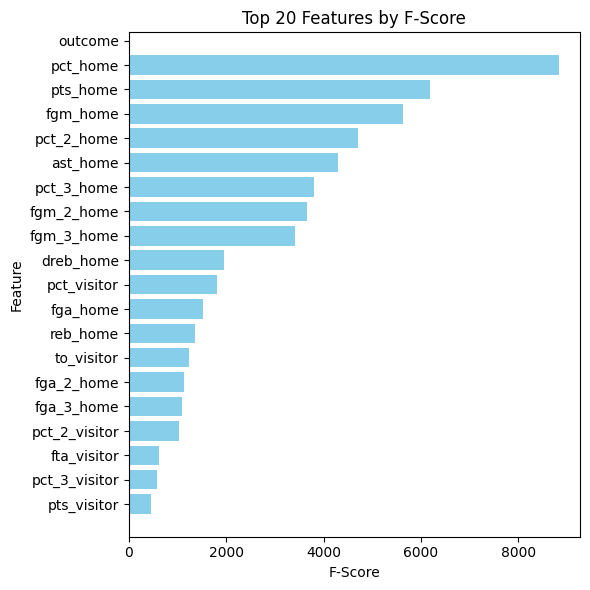

In [9]:
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

# Perform ANOVA analysis
f_scores, p_values = f_classif(data, data['outcome'])

# Create a DataFrame to store feature importance scores
feature_importance = pd.DataFrame({'Feature': data.columns, 'F_Score': f_scores, 'P_Value': p_values})

# Sort features by F-score in descending order
feature_importance.sort_values(by='F_Score', ascending=False, inplace=True)

N = 20  # Number of top features to display
top_features = feature_importance.nlargest(N, 'F_Score')

plt.figure(figsize=(6, 6))
plt.barh(top_features['Feature'], top_features['F_Score'], color='skyblue')
plt.xlabel('F-Score')
plt.ylabel('Feature')
plt.title(f'Top {N} Features by F-Score')
plt.gca().invert_yaxis()  # Invert y-axis to display highest score at the top
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

In [10]:
# Calculate correlation matrix for numeric columns
correlation_matrix = data.corr(method='spearman')

# Print correlation coefficients with the target variable
print(correlation_matrix['outcome'].sort_values(ascending=False))


outcome          1.000000
pts_home         0.577303
pct_home         0.566263
fgm_home         0.557521
ast_home         0.476342
fgm_2_home       0.446611
pct_2_home       0.437015
pct_3_home       0.400510
fgm_3_home       0.397120
fga_home         0.333043
dreb_home        0.322664
reb_home         0.287417
fga_2_home       0.285226
to_visitor       0.247097
fga_3_home       0.239137
fta_visitor      0.160853
blk_visitor      0.117372
oreb_visitor     0.102556
oreb_home        0.100740
fga_visitor      0.099120
fga_2_visitor    0.094586
fga_3_visitor    0.068299
home_3           0.037034
reb_visitor      0.035101
home_1           0.025778
home_2           0.025541
blk_home         0.019358
away_team        0.013736
home_0           0.013324
away_4           0.007389
fta_home         0.006450
away_0           0.004108
home_4           0.002935
away_2          -0.005473
away_1          -0.005575
away_3          -0.008005
end_min         -0.023134
dreb_visitor    -0.025699
starting_min

In [11]:
# Filter features with correlation 
#selected_features = correlation_matrix[(correlation_matrix['outcome'].abs() < 0.12)].index
selected_features = correlation_matrix[(correlation_matrix['outcome'] >= -0.02) & (correlation_matrix['outcome'] <= 0.12)].index

# Add the target variable to the selected features
selected_features = selected_features.append(pd.Index(['outcome']))

# Copy selected features to another dataset
data_selected = data[selected_features].copy()

# Print the final selected features
print("Selected features:")
print(data_selected.columns)

Selected features:
Index(['away_team', 'home_0', 'home_1', 'home_2', 'home_3', 'home_4', 'away_0',
       'away_1', 'away_2', 'away_3', 'away_4', 'fta_home', 'blk_home',
       'oreb_home', 'fga_visitor', 'fga_2_visitor', 'fga_3_visitor',
       'blk_visitor', 'reb_visitor', 'oreb_visitor', 'outcome'],
      dtype='object')


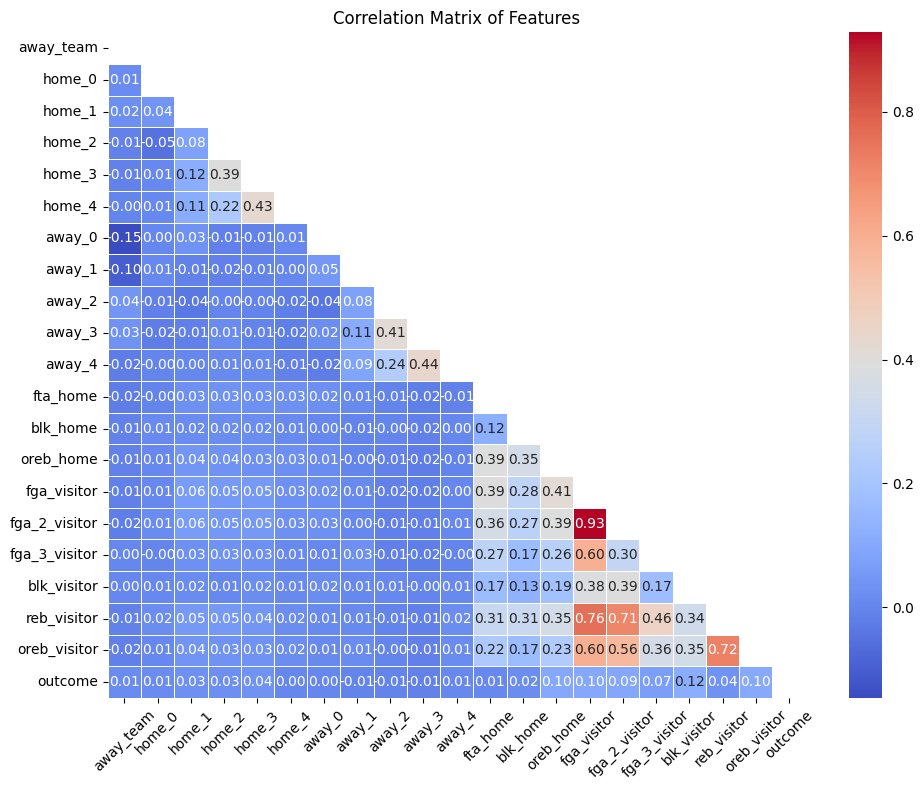

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
# Generate a mask for the upper triangle
# Calculate correlation matrix for numeric columns
correlation_matrix = data_selected.corr(method='spearman')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Customize plot
plt.title('Correlation Matrix of Features')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show plot
plt.show()

In [13]:
data_selected.drop(['fga_2_visitor'], axis=1, inplace=True)
selected_features = selected_features.drop('fga_2_visitor', errors='ignore')

data_selected

,away_team,home_0,home_1,home_2,home_3,home_4,away_0,away_1,away_2,away_3,away_4,fta_home,blk_home,oreb_home,fga_visitor,fga_3_visitor,blk_visitor,reb_visitor,oreb_visitor,outcome
0,1025,1068,1173,1087,1231,1398,1191,1218,1325,1392,1457,3,1,1,11,3,0,8,2,1
1,1025,1173,1068,1087,1269,1466,1191,1218,1325,1392,1457,0,0,0,2,1,0,1,0,-1
2,1025,1173,1068,1087,1269,1466,1079,1218,1325,1392,1457,0,0,0,4,1,1,4,1,-1
3,1025,1068,1173,1269,1331,1466,1080,1079,1218,1325,1457,0,0,0,4,1,0,2,0,-1
4,1025,1173,1066,1269,1331,1466,1080,1079,1229,1218,1397,0,0,0,2,2,0,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21236,1016,1109,1340,1320,1401,1493,1201,1134,1031,1365,1386,0,0,0,0,0,0,0,0,-1
21237,1016,1109,1340,1320,1401,1493,1201,1031,1115,1365,1386,0,0,0,0,0,0,0,0,-1
21238,1016,1109,1138,1178,1340,1401,1201,1031,1115,1365,1386,0,0,0,0,0,0,0,0,-1
21239,1016,1109,1178,1340,1401,1493,1201,1031,1115,1365,1386,0,0,0,0,0,0,0,0,-1


In [14]:
data_selected['outcome'].value_counts()

outcome
-1    13454
 1     7787
Name: count, dtype: int64

In [15]:
# Split the data into features (X) and target variable (y)
y = data_selected['outcome']
X = data_selected.drop(columns=['outcome'])

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# # Split the resampled data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [16]:
y_resampled.value_counts()

outcome
 1    13454
-1    13454
Name: count, dtype: int64

In [17]:
#Baseline Random Forest Classifier 

# Train a random forest classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the performance of random forest classifier model
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print("\nRandom Forest Classifier Model:")
print("Accuracy:", accuracy_rf)
print("F1 Score:", f1_rf)
print("Recall Score:", recall_rf)

# Generate and print the classification report
report = classification_report(y_test, y_pred_rf)
print("Classification Report:")
print(report)


Random Forest Classifier Model:
Accuracy: 0.7014121144555927
F1 Score: 0.7064840182648402
Recall Score: 0.7162962962962963
Classification Report:
              precision    recall  f1-score   support

          -1       0.71      0.69      0.70      2682
           1       0.70      0.72      0.71      2700

    accuracy                           0.70      5382
   macro avg       0.70      0.70      0.70      5382
weighted avg       0.70      0.70      0.70      5382



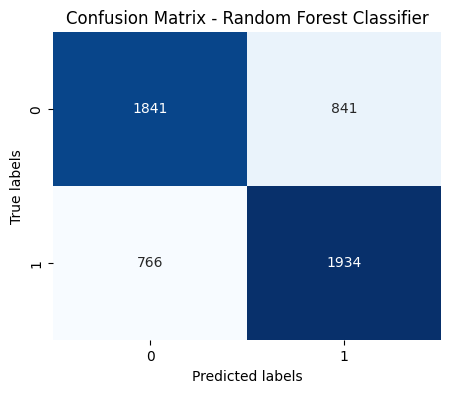

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()


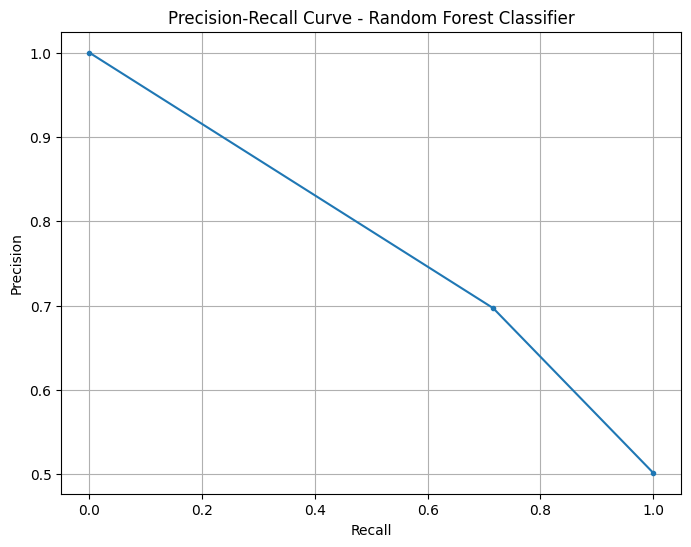

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_rf)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest Classifier')
plt.grid(True)
plt.show()


In [20]:
#MLP Classifier
from sklearn.neural_network import MLPClassifier

# Define class weights
# Assuming 'class_weight' is a dictionary where keys are class labels and values are corresponding weights
class_weight = {-1: 1, 1: 5}

# Train a new DNN Classifier with selected features
dnn_classifier = MLPClassifier(random_state=42, max_iter=500)
dnn_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_mlp = dnn_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_mlp)
f1 = f1_score(y_test, y_pred_mlp)
recall = recall_score(y_test, y_pred_mlp)

print("\nMLP Classifier Model:")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall Score:", recall)

# Generate and print the classification report
report = classification_report(y_test, y_pred_mlp)
print("Classification Report:")
print(report)


MLP Classifier Model:
Accuracy: 0.6361947231512449
F1 Score: 0.6561292588689849
Recall Score: 0.6918518518518518
Classification Report:
              precision    recall  f1-score   support

          -1       0.65      0.58      0.61      2682
           1       0.62      0.69      0.66      2700

    accuracy                           0.64      5382
   macro avg       0.64      0.64      0.63      5382
weighted avg       0.64      0.64      0.64      5382



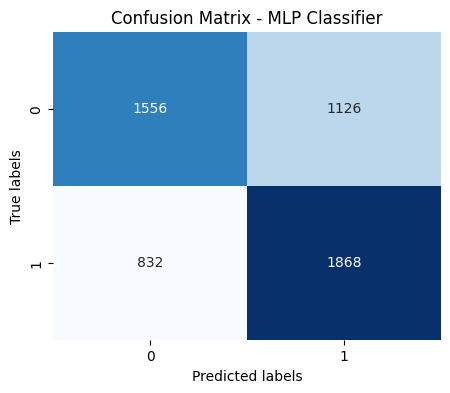

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_mlp)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - MLP Classifier')
plt.show()

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Creating an instance of KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=10)  # Example: setting number of neighbors to 5

# Training the classifier
knn_classifier.fit(X_train_scaled, y_train)  # Assuming X_train and y_train are your training data

# Making predictions
y_pred_knn = knn_classifier.predict(X_test_scaled)  # Assuming X_test is your test data

accuracy = accuracy_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)

print("\nKNN Model:")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall Score:", recall)

# Generate and print the classification report
report = classification_report(y_test, y_pred_mlp)
print("Classification Report:")
print(report)


KNN Model:
Accuracy: 0.6060943887030844
F1 Score: 0.6079881656804734
Recall Score: 0.6088888888888889
Classification Report:
              precision    recall  f1-score   support

          -1       0.65      0.58      0.61      2682
           1       0.62      0.69      0.66      2700

    accuracy                           0.64      5382
   macro avg       0.64      0.64      0.63      5382
weighted avg       0.64      0.64      0.64      5382



In [23]:
from sklearn.tree import DecisionTreeClassifier

# Creating an instance of DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier(random_state=42)  # Example: setting random_state for reproducibility

# Training the classifier
decision_tree_classifier.fit(X_train_scaled, y_train)  # Assuming X_train_scaled and y_train are your scaled training data

# Making predictions
y_pred_decision_tree = decision_tree_classifier.predict(X_test_scaled)  # Assuming X_test_scaled is your scaled test data
accuracy = accuracy_score(y_test, y_pred_decision_tree)
f1 = f1_score(y_test, y_pred_decision_tree)
recall = recall_score(y_test, y_pred_decision_tree)

print("\nDecision Tree Classifier Model:")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall Score:", recall)

# Generate and print the classification report
report = classification_report(y_test, y_pred_decision_tree)
print("Classification Report:")
print(report)


Decision Tree Classifier Model:
Accuracy: 0.6257896692679301
F1 Score: 0.6222805701425357
Recall Score: 0.6144444444444445
Classification Report:
              precision    recall  f1-score   support

          -1       0.62      0.64      0.63      2682
           1       0.63      0.61      0.62      2700

    accuracy                           0.63      5382
   macro avg       0.63      0.63      0.63      5382
weighted avg       0.63      0.63      0.63      5382



In [24]:
# Load the real dataset
real_data = pd.read_csv('test.csv')  
real_data

,game,season,home_team,away_team,starting_min,end_min,home_0,home_1,home_2,home_3,...,pf_visitor,reb_visitor,dreb_visitor,oreb_visitor,to_visitor,pts_visitor,pct_visitor,pct_2_visitor,pct_3_visitor,outcome
0,200612290WAS,2007,WAS,ORL,39,41,Antawn Jamison,Antonio Daniels,Calvin Booth,Gilbert Arenas,...,1,1,1,0,0,4,1.000000,1.000000,0,1
1,200612300MIL,2007,MIL,WAS,5,6,Andrew Bogut,Brian Skinner,Charlie Bell,Michael Redd,...,1,2,2,0,0,2,0.200000,0.333333,0,1
2,200612300MIL,2007,MIL,WAS,15,17,Andrew Bogut,Michael Redd,Mo Williams,Ruben Patterson,...,1,5,4,1,1,4,0.333333,0.666667,0,1
3,200612300MIL,2007,MIL,WAS,18,21,Andrew Bogut,Michael Redd,Mo Williams,Ruben Patterson,...,0,5,5,0,3,4,0.400000,0.500000,0,1
4,200612300MIL,2007,MIL,WAS,25,28,Andrew Bogut,Brian Skinner,Charlie Bell,Michael Redd,...,1,2,1,1,1,8,0.400000,0.400000,0,1
5,200612300MIL,2007,MIL,WAS,36,36,Andrew Bogut,Charlie Bell,Michael Redd,Ruben Patterson,...,0,0,0,0,0,0,0.000000,0.000000,0,1
6,200612300MIL,2007,MIL,WAS,37,39,Brian Skinner,Charlie Bell,Michael Redd,Ruben Patterson,...,0,3,2,1,2,2,0.200000,0.200000,0,1
7,200612300MIL,2007,MIL,WAS,40,41,Brian Skinner,Charlie Bell,Michael Redd,Ruben Patterson,...,0,2,0,2,0,2,0.333333,0.333333,0,1
8,200612300MIL,2007,MIL,WAS,42,42,Brian Skinner,Charlie Bell,Michael Redd,Mo Williams,...,0,0,0,0,0,0,0.000000,0.000000,0,1
9,200612300MIL,2007,MIL,WAS,43,44,Brian Skinner,Charlie Bell,Michael Redd,Mo Williams,...,0,2,0,2,0,6,0.500000,0.500000,0,1


In [25]:

# Select only the features selected during training
real_data_selected = real_data[selected_features[:-1]]  # Exclude the target variable 'outcome'
# Use the same mapping for new data
for col in player_name_columns:
    if col in real_data_selected.columns:
        real_data_selected.loc[:, col] = player_encoder.transform(real_data_selected[col]).astype(int)

real_data_selected

,away_team,home_0,home_1,home_2,home_3,home_4,away_0,away_1,away_2,away_3,away_4,fta_home,blk_home,oreb_home,fga_visitor,fga_3_visitor,blk_visitor,reb_visitor,oreb_visitor
0,1019,1171,1507,1507,1046,1507,1507,1162,1323,1358,1434,1,0,3,2,0,0,1,0
1,1012,1095,1504,1507,1292,1204,1171,1507,1219,1184,1046,0,0,1,5,2,0,2,0
2,1012,1095,1292,1204,1507,1468,1277,1507,1507,1219,1507,1,1,1,6,3,0,5,1
3,1012,1095,1292,1204,1507,1468,1277,1171,1184,1046,1507,2,0,1,5,1,0,5,0
4,1012,1095,1504,1507,1292,1204,1171,1507,1219,1184,1046,5,1,3,10,0,0,2,1
5,1012,1095,1507,1292,1507,1468,1507,1507,1219,1046,1507,0,0,0,1,1,0,0,0
6,1012,1504,1507,1292,1507,1468,1507,1507,1219,1046,1507,1,0,1,5,0,0,3,1
7,1012,1504,1507,1292,1507,1468,1171,1507,1219,1184,1046,0,0,1,3,0,1,2,2
8,1012,1504,1507,1292,1204,1507,1171,1507,1219,1184,1046,0,0,0,1,0,0,0,0
9,1012,1504,1507,1292,1204,1507,1171,1219,1184,1046,1507,2,0,0,6,0,0,2,2


In [26]:
# Scale the features using the same scaler
X_real_scaled = scaler.transform(real_data_selected)

# Make predictions on the real data using the trained random forest classifier
y_pred_real = rf_model.predict(X_real_scaled)

# Print the predictions
print("Predictions on real data:", y_pred_real)

Predictions on real data: [ 1 -1 -1  1 -1 -1 -1  1 -1 -1 -1]


In [27]:
# Scale the features using the same scaler
X_real_scaled = scaler.transform(real_data_selected)

# Make predictions on the real data using the trained MLP classifier
y_pred_real = dnn_classifier.predict(X_real_scaled)

# Print the predictions
print("Predictions on real data:", y_pred_real)

Predictions on real data: [-1 -1 -1 -1 -1 -1  1  1  1  1  1]
